In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from src.utilities import load_data, plot_feature_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn import decomposition
sns.set()
sns.set(color_codes=True)
sns.set(font_scale=1.2)
#plt.style.use('seaborn')
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
X_df = load_data(filename='../data/data_withLattice.csv')
X_features = X_df.iloc[:, 1:-5]
feature_names = X_features.columns.values

y_multilabel = X_df.iloc[:, -5:]
label_names = y_multilabel.columns.values

print('Feature names: \n', feature_names)
print('Label names: ', label_names)

Feature names: 
 ['Sc' 'Ti' 'V' 'Cr' 'Zr' 'Nb' 'Mo' 'Hf' 'Ta' 'C' 'N' 'F' 'H' 'O' 'OH'
 'NULL' 'Li' 'Na' 'K' 'Mg']
Label names:  ['Voltage(V)' 'Theoretical_capacity (mAh/g)' 'Induced_Z_charge(mAh/g)'
 'In-plane lattice' 'In-plane lattice(intercalated)']


In [33]:
X = X_features.to_numpy()
y = y_multilabel.to_numpy()
scaler = preprocessing.MinMaxScaler()
y = scaler.fit_transform(y)
data_index = []
for index, row in X_features.iterrows():
    indices = [i for i, x in enumerate(row) if x == 1]
    indices[1] = indices[1] - 9
    indices[2] = indices[2] - 11
    indices[3] = indices[3] - 16
    data_index.append(indices)
X_features_classes = np.array(data_index)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_features_classes, y, test_size=0.2, random_state=42)

### Search best parameters and find the RF

In [35]:
model_RFR = RandomForestRegressor(random_state=42, max_features=None,n_jobs=-1, criterion='squared_error',min_impurity_decrease=1e-07,max_depth=14, min_samples_leaf=1,min_samples_split=2, n_estimators=200)

### Evaluate the model using the same test set

In [38]:
model_RFR.fit(X_train, y_train)
cv_scores = cross_val_score(model_RFR, X_train, y_train, cv=10)
mse = mean_squared_error(y_test, model_RFR.predict(X_test))
r2 = r2_score(y_test, model_RFR.predict(X_test))
mae = mean_absolute_error(y_test, model_RFR.predict(X_test))
print('R2 (train):', np.round(r2_score(y_train, model_RFR.predict(X_train)), 6))
print('R2 (test):', np.round(r2, 6))
print('MAE:', np.round(mae, 6))
print('MSE:', np.round(mse, 6))

R2 (train): 0.968486
R2 (test): 0.790246
MAE: 0.056806
MSE: 0.00833


### Ground truth vs predictions

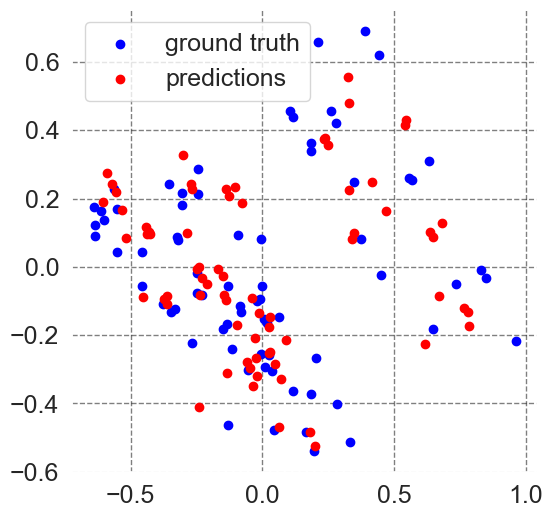

In [37]:
pca = decomposition.PCA(n_components=2)
# tsne = TSNE(n_components=2, verbose=1, random_state=123)
z_rf = pca.fit_transform(y_test)
z_pred_rf = pca.fit_transform(model_RFR.predict(X_test))
fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(111)
ax.scatter(z_rf[:, 0], z_rf[:, 1], color='blue', label='ground truth')
ax.scatter(z_pred_rf[:, 0], z_pred_rf[:, 1], color='red', label='predictions')
# ax.set_axisbelow(True)
ax.xaxis.grid(False, color="black", linestyle='--', lw=1, alpha=0.5)
ax.yaxis.grid(False, color="black", linestyle='--', lw=1, alpha=0.5)
# ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_facecolor("white")
ax.legend(loc=2, shadow=False, facecolor='white', fontsize=18)
# ax.set_xlabel('PCA',fontsize=18)
plt.savefig('../results/figs/pred_vs_gth_rf_cat.png', bbox_inches='tight')
plt.show()